# mencari kata kunci pada berita

## preprocessing text

### import library

In [71]:
import pandas as pd
import nltk
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations


### load data

In [72]:
df = pd.read_csv('berita_kompas.csv')
df.head()

,judul,isi,tanggal,kategori
0,"Tiga Pengeroyok di Cakung Ditangkap, Satu Lain...","JAKARTA, KOMPAS.com - Jajaran Satreskrim Polre...","Kompas.com - 10/09/2024, 12:27 WIB",Megapolitan
1,Puan Beri Sinyal RUU Perampasan Aset Tak Disel...,"JAKARTA, KOMPAS.com - Ketua DPR RI Puan Mahara...","Kompas.com - 10/09/2024, 12:26 WIB",Nasional
2,PDI-P Duga Gugatan SK Kepengurusan Upaya Sabot...,"JAKARTA, KOMPAS.com - Ketua Dewan Pimpinan Pus...","Kompas.com - 10/09/2024, 12:24 WIB",Nasional
3,Jalan Jatiwaringin Bekasi Arah Jakarta Macet I...,"BEKASI, KOMPAS.com - Arus lalu lintas di Jalan...","Kompas.com - 10/09/2024, 12:17 WIB",Megapolitan
4,Nasib Taruna Akpol Usai Dipecat karena Lawan P...,"JAKARTA, KOMPAS.com - Taruna Akpol berinisial...","Kompas.com - 10/09/2024, 12:16 WIB",Nasional


### preprocessing data

In [73]:
def preptext(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Menghapus https* and www*
    text = re.sub(r'[\s]+', ' ', text) # Menghapus tambahan spasi
    text = re.sub(r"[^a-zA-Z :\.]", "", text) # Menghapus tanda baca
    text = re.sub(r'\d', ' ', text)#menghapus angka
    text = re.sub(r'#([^\s]+)', ' ', text)#menghapus hashtag
    words = word_tokenize(text.lower())

    sw = set(stopwords.words("indonesian"))
    words = [word for word in words if word.lower() not in sw]
    return ' '.join(words)

df['isi_baru'] = df['isi'].apply(preptext)
print(df['isi_baru'].head())

0    jakarta kompas.com jajaran satreskrim polres m...
1    jakarta kompas.com ketua dpr ri puan maharani ...
2    jakarta kompas.com ketua dewan pimpinan pusat ...
3    bekasi kompas.com arus lintas jalan jatiwaring...
4    jakarta kompas.com taruna akpol berinisial bva...
Name: isi_baru, dtype: object


### memisahkan kalimat

In [74]:
no = int(input('Masukkan berita ke berapa yang ingin di cari kata kuncinya : '))
kalimat = nltk.sent_tokenize(df['isi_baru'][no])
kalimat = [sentence.replace('.','') for sentence in kalimat]
kata = nltk.word_tokenize(df['isi_baru'][no])
kata = list(set(key for key in kata if key != '.'))

kalimat

['jakarta kompascom pencabutan ketetapan majelis permusyawaratan rakyat tap mprs nomor penutup babak ketidakadilan dialami soekarno mengembalikan posisinya pahlawan nasional dibayangi tuduhan berdasar ',
 'langkah kesempatan bangsa indonesia mengakui peran soekarno sejarah bayangbayang kontroversi politik ',
 'tap mprs nomor tonggak sejarah peralihan kekuasaan presiden soekarno orde ',
 'penetapan mencabut kekuasaan pemerintahan presiden soekarno krisis politik memuncak peristiwa gerakan september gs ',
 'keputusan diambil ketidakpuasan terkait kebijakan diambil soekarno peristiwa gs ',
 'baca : tap mpr resmi dicabut tuduhan soekarno berkhianat dukung pki terbukti majelis permusyawaratan rakyat mprs menggelar sidang soekarno pertanggungjawaban kebijakan diambil krisis nasional ',
 'soekarno pidato pertanggungjawaban dikenal nawaksara juni ',
 'pidato dianggap memenuhi harapan memuat pertanggungjawaban rinci terkait keterlibatannya peristiwa gs situasi nasional ',
 'pidato nawaksara dit

In [75]:
kata

['diambil',
 'kepemimpinan',
 'mengajukan',
 'penghargaan',
 'pencabutan',
 'operasi',
 'bukti',
 'kekuasaan',
 'berdasar',
 'proses',
 'harapan',
 'ketidakadilan',
 'bamsoet',
 'pemerintahan',
 'terlibat',
 'pandangan',
 'mprs',
 'gerakan',
 'kesempatan',
 'rangkul',
 'surat',
 'nama',
 'upaya',
 'juni',
 'pemulihan',
 'majelis',
 'khusus',
 'gs',
 'obrolan',
 'september',
 'krisis',
 'komitmen',
 'bambang',
 'soekarno',
 'beliau',
 'fasilitas',
 'istimewa',
 'pertanggungjawaban',
 'negara',
 'hasil',
 'memuat',
 'mengakui',
 'ketetapan',
 'hakhak',
 'pidato',
 'gerindra',
 'dianggap',
 'perumahan',
 'acara',
 'keterlibatannya',
 'sejarah',
 'dialami',
 'kebijakan',
 'hukum',
 'hakhaknya',
 'soesatyo',
 'berkhianat',
 'pemberontakan',
 'laporan',
 'bentuk',
 ':',
 'sah',
 'bangsa',
 'politik',
 'nomor',
 'jakarta',
 'resmi',
 'menetapkan',
 'situasi',
 'status',
 'memadai',
 'keterlibatan',
 'penutup',
 'ditolak',
 'baca',
 'rinci',
 'periode',
 'ketidakpuasan',
 'sidang',
 'mencabut'

## modeling

### membuat matrix

In [76]:
def vektor_kata(data):
    vektor_kata = pd.DataFrame(0, index=range(len(data)), columns=kata)
    
    for i, sent in enumerate(data):
        # Tokenisasi kalimat menjadi kata-kata
        kata_kalimat = word_tokenize(sent)
        
        # Hitung frekuensi kata menggunakan Counter
        freq_kata = Counter(kata_kalimat)
        
        # Update DataFrame dengan frekuensi kata yang ditemukan dalam kata
        for word, count in freq_kata.items():
            if word in kata:
                vektor_kata.at[i, word] = count

    return vektor_kata

vektorisasi_kata = vektor_kata(kalimat)
print(vektorisasi_kata)

    diambil  kepemimpinan  mengajukan  penghargaan  pencabutan  operasi  \
0         0             0           0            0           1        0   
1         0             0           0            0           0        0   
2         0             0           0            0           0        0   
3         0             0           0            0           0        0   
4         2             0           0            0           0        0   
5         1             0           0            0           0        0   
6         0             0           0            0           0        0   
7         0             0           0            0           0        0   
8         0             0           1            0           0        0   
9         0             0           0            0           0        0   
10        0             0           0            0           0        0   
11        0             0           0            0           0        1   
12        0             1

### hasil kata kunci

In [77]:
kunci = vektorisasi_kata.sum().sort_values(ascending=False)[:4]
print(", ".join(kunci.index))

soekarno, tap, mprs, pencabutan


### co-occurrence matrix

In [78]:
def cooc_matrix(data):
    vektor_kata = pd.DataFrame(0, index=kata, columns=kata)
    
    for sent in data:
        kata_kalimat = word_tokenize(sent)
        
        for word1, word2 in combinations(kata_kalimat, 2):#mencari kata yg sering muncul menggunakan combination
            if word1 in kata and word2 in kata:
                # Tambahkan ke matrix untuk kedua arah (word1, word2) dan (word2, word1)
                vektor_kata.at[word1, word2] += 1
                vektor_kata.at[word2, word1] += 1

    return vektor_kata

cooccurrence_matrix = cooc_matrix(kalimat)
print(cooccurrence_matrix)
kunci2 = cooccurrence_matrix.sum().sort_values(ascending=False)[:4]
kunci2

              diambil  kepemimpinan  mengajukan  penghargaan  pencabutan  \
diambil             2             0           0            0           0   
kepemimpinan        0             0           0            0           1   
mengajukan          0             0           0            0           0   
penghargaan         0             0           0            0           0   
pencabutan          0             1           0            0           0   
...               ...           ...         ...          ...         ...   
maret               0             0           0            0           0   
lelaki              0             0           0            1           0   
mencakup            0             0           0            0           0   
terkait             2             0           0            0           0   
pengkhianat         0             0           0            0           1   

              operasi  bukti  kekuasaan  berdasar  proses  ...  nawaksara  \
diambil   

soekarno    240
tap         114
mprs        106
mpr          92
dtype: int64

### cosine similaritas

Rumus Cosine Similarity:
cosine similarity
=
𝐴
⋅
𝐵
/
∥
𝐴
∥
∥
𝐵
∥
cosine similarity= 
∥A∥∥B∥
A⋅B
​
 


In [79]:
cosine = cosine_similarity(cooccurrence_matrix)
cosine

array([[1.        , 0.31212739, 0.13900961, ..., 0.        , 0.61655316,
        0.31212739],
       [0.31212739, 1.        , 0.13608276, ..., 0.        , 0.24142866,
        0.5       ],
       [0.13900961, 0.13608276, 1.        , ..., 0.        , 0.14784425,
        0.13608276],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.61655316, 0.24142866, 0.14784425, ..., 0.        , 1.        ,
        0.27160724],
       [0.31212739, 0.5       , 0.13608276, ..., 0.        , 0.27160724,
        1.        ]])

### buat dalam bentuk graph

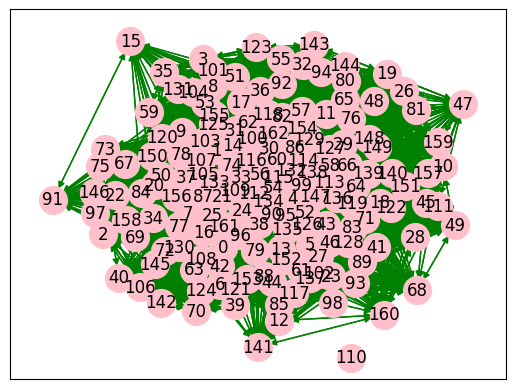

In [80]:
G = nx.DiGraph()
for i in range(len(cosine)):
    G.add_node(i)

for i in range(len(cosine)):
    for j in range(len(cosine)):
        similarity = cosine[i][j]
        if similarity > 0.1 and i != j:
            G.add_edge(i, j)

pos = nx.spring_layout(G, k=2)
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
nx.draw_networkx_edges(G, pos, edge_color='green', arrows=True)
nx.draw_networkx_labels(G, pos)

plt.show()

### pemeringkatan node


In [92]:
rank_word = nx.pagerank(G)

sorted_pagerank= sorted(rank_word.items(), key=lambda x: x[1], reverse=True)
print("Ranked page berita ke-",no,":")
for node, pagerank in sorted_pagerank:
    print(f"Node {node}: {pagerank:.4f}")

Ranked page berita ke- 7 :
Node 33: 0.0087
Node 56: 0.0085
Node 95: 0.0085
Node 112: 0.0085
Node 114: 0.0085
Node 115: 0.0085
Node 132: 0.0085
Node 30: 0.0084
Node 147: 0.0084
Node 60: 0.0084
Node 74: 0.0084
Node 24: 0.0084
Node 4: 0.0082
Node 21: 0.0081
Node 99: 0.0081
Node 52: 0.0081
Node 105: 0.0080
Node 134: 0.0080
Node 138: 0.0080
Node 162: 0.0080
Node 90: 0.0079
Node 66: 0.0078
Node 1: 0.0078
Node 31: 0.0078
Node 54: 0.0078
Node 87: 0.0078
Node 100: 0.0078
Node 103: 0.0078
Node 107: 0.0078
Node 109: 0.0078
Node 129: 0.0078
Node 25: 0.0078
Node 37: 0.0078
Node 96: 0.0078
Node 126: 0.0078
Node 133: 0.0078
Node 38: 0.0076
Node 135: 0.0076
Node 136: 0.0076
Node 156: 0.0075
Node 16: 0.0074
Node 78: 0.0074
Node 161: 0.0074
Node 62: 0.0074
Node 7: 0.0073
Node 0: 0.0073
Node 43: 0.0072
Node 13: 0.0072
Node 77: 0.0072
Node 79: 0.0072
Node 113: 0.0071
Node 29: 0.0071
Node 5: 0.0070
Node 14: 0.0070
Node 86: 0.0070
Node 116: 0.0070
Node 119: 0.0070
Node 127: 0.0070
Node 128: 0.0070
Node 152:

### hasil kata kunci 

In [87]:
print("4 rank node teratas dari berita ke ",no ,":")
sentence = ""
for node, pagerank in sorted_pagerank[:4]:
  top_sentence = kata[node]
  sentence += top_sentence + ", "
  print(f"Node {node}: Page Rank = {pagerank:.4f}")
  print(f"kata: {top_sentence}")

4 rank node teratas dari berita ke  7 :
Node 33: Page Rank = 0.0087
kata: soekarno
Node 56: Page Rank = 0.0085
kata: berkhianat
Node 95: Page Rank = 0.0085
kata: menggelar
Node 112: Page Rank = 0.0085
kata: dicabut
